# Natural Language Processing with Disaster Tweets

## Table of Contents

1. [Introduction](#1)
2. [EDA](#2)
3. [Plan](#3)
4. [Model](#4)

    4.1. [Text Vectorization](#8)
    
    4.2. [RNN](#9)
5. [Training](#5)
6. [Results](#6)

    6.1. [Training Curves](#10)
    
    6.2. [Submission](#11)
7. [Conclusion](#7)



<a id="1"></a>
## 1. Introduction




Natural Language Processing is a field that helps computers understand and work with human language. In this notebook, I will be using a Recurrent Neural Network to identify tweets that are related to real disasters. This skill can be incredibly useful for quickly spotting emergency situations and helping responders take action. The dataset is provided by Kaggle and is available [here](https://www.kaggle.com/competitions/nlp-getting-started/overview). The data is split into a training and test set and is in csv format. 

<a id="2"></a>
## 2. EDA

Let's start by looking importing the data. There are 5 columns, `id`, `keyword`, `location`, `text`, and `target`. We will only need the `text` and `target` for this column. The `text` column contains the tweet as a string and the `target` contains the label. There are 7613 rows of training data and no missing values for `text` and `target`. 

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

data.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
data[data.keyword.notna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


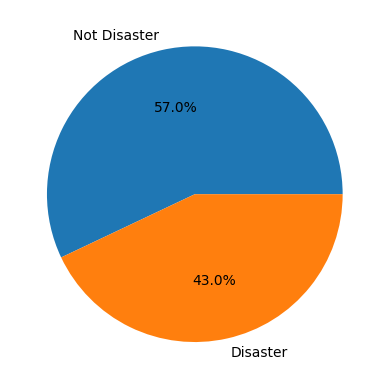

In [4]:
import matplotlib.pyplot as plt

plt.pie(data.target.value_counts(),
        labels=['Not Disaster','Disaster'],
        autopct='%1.1f%%')
plt.show()


The dataset is relatively well balanced where 57% of the data is not concerning a disaster and 43% is concerning a disaster. I do not see a need to balance the dataset for this project. 

### Data Cleaning

The text data will need to be cleaned before it can be used in the machine learning process. The text will be converted to lower case and the links / emojis will be removed. 

In [5]:
import re

def clean_text_data(df):
    # Make text lowercase
    df['text'] = df['text'].str.lower()

    # Remove links (URLs)
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

    # Remove emojis (Unicode characters)
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    return df

In [6]:
data = clean_text_data(data)
test = clean_text_data(test)

<a id="3"></a>
## 3. Plan

I will be following [tensorflow's guide](https://www.tensorflow.org/text/tutorials/text_classification_rnn) for text classification with an RNN for this project. The model architecture is depicted in the image below. 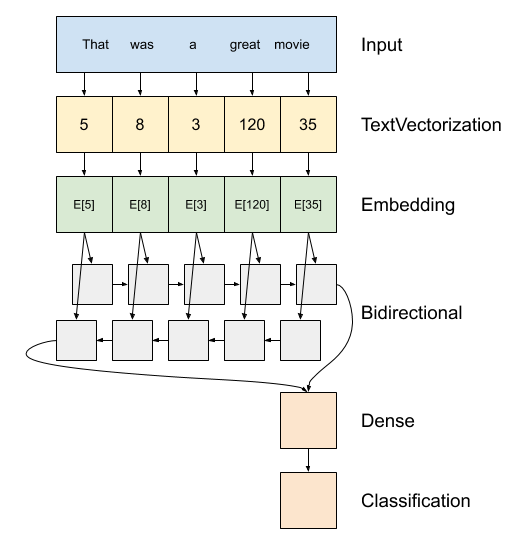

<a id="4"></a>
## 4. Model

<a id="8"></a>
### 4.1. Text Vectorization

The text data needs to be vectorized first before it can be used for training. I will use tensorflow's `TextVectorization` to accomplish this. Text vectorization converts strings of text into a sequence of integers. The most frequent words in the text dataset are assigned integer values and once the maximum number of words is reached the vectorizer assigns a value for the out of vocabulary words. This method only converts the string into a numerical representation and does not capture any contextual meaning behind the words. The vocab size used for the vectorization has a significant effect on the training. If it is too large it will overfit to the training data very easily. I found that a vocab size of ~2000 worked well for this project. 

In [7]:
import tensorflow as tf

VOCAB_SIZE = 2000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(data.text.to_list())

vectorized_text = encoder(data.text).numpy()

vectorized_text[:5]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[ 109,    1,   22,    2,  835,    6,   19,  251,  126, 1692,    1,
          70,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 180,   43,  221,  668,    1,    1, 1434,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  39, 1745, 1688,    5,    1,    4,  662,   22,  123,    1,   18,
        1766,   42,  379,  250,   55,    1,    4,  662, 1387,   22, 1104,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,   57,    1, 1356,  250, 1387,    4,   88,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  29,   95, 1199,   19,  328,   20,    1,    1,   26,  258,   20,
        1356,    1,   66,    3,  176,    0,    0,    0,    0,    0,    0,
        

<a id="9"></a>
### 4.2. RNN

The model architecture is shown below. 

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import f1_score

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 589,825
Trainable params: 589,825
Non-trai

<a id="5"></a>
## 5. Training

20% of the data will be set aside for validation. I will also define a custom learning rate and include early stopping for the training. This should help with overfitting and accuracy.

In [10]:
def custom_learning_rate(epoch):
    initial_lr = 0.00006
    drop = 0.95
    epochs_drop = 3

    lr = initial_lr * (drop ** (epoch // epochs_drop))
    
    return lr

lr_scheduler = LearningRateScheduler(custom_learning_rate)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
history = model.fit(np.array(data.text), 
                    data.target, 
                    epochs=50, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

Epoch 1/50
191/191 [==============================] - 31s 100ms/step - loss: 0.6760 - accuracy: 0.5837 - val_loss: 0.6679 - val_accuracy: 0.5785 - lr: 6.0000e-05
Epoch 2/50
191/191 [==============================] - 5s 25ms/step - loss: 0.5610 - accuracy: 0.7378 - val_loss: 0.5113 - val_accuracy: 0.7669 - lr: 6.0000e-05
Epoch 3/50
191/191 [==============================] - 4s 22ms/step - loss: 0.4463 - accuracy: 0.8123 - val_loss: 0.4738 - val_accuracy: 0.7702 - lr: 6.0000e-05
Epoch 4/50
191/191 [==============================] - 5s 23ms/step - loss: 0.4018 - accuracy: 0.8361 - val_loss: 0.4606 - val_accuracy: 0.7827 - lr: 5.7000e-05
Epoch 5/50
191/191 [==============================] - 3s 18ms/step - loss: 0.3721 - accuracy: 0.8534 - val_loss: 0.4668 - val_accuracy: 0.7768 - lr: 5.7000e-05
Epoch 6/50
191/191 [==============================] - 3s 17ms/step - loss: 0.3537 - accuracy: 0.8567 - val_loss: 0.4559 - val_accuracy: 0.7912 - lr: 5.7000e-05
Epoch 7/50
191/191 [==================

<a id="6"></a>
## 6. Results

<a id="10"></a>
### Training Curves

We want the loss and the validation loss to both decrease and the accuracy and the validation accuracy to increase. We can see the best validation accuracy is at epoch 3 and the model starts to overfit in the later epochs. The early stoppng will restore the best weights which we will use for the prediction.

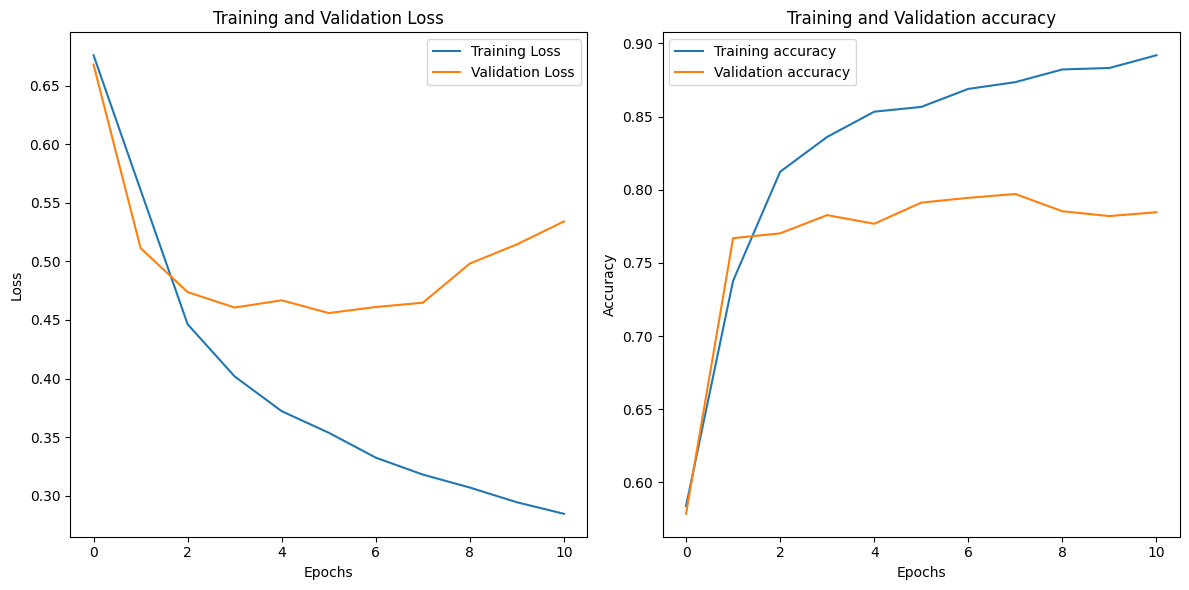

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

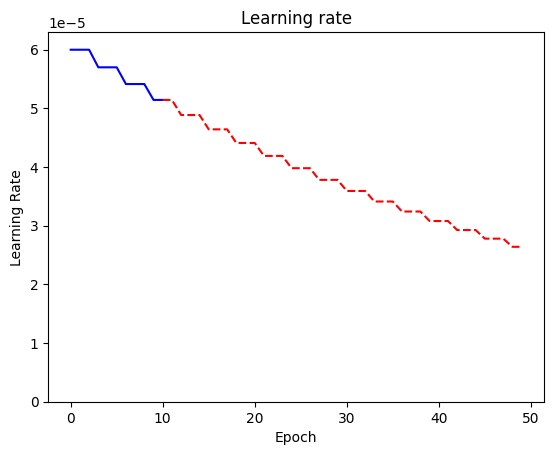

In [13]:
x = range(50)
n = len(history.history['lr'])
lrs_0 = [custom_learning_rate(i) for i in x[:n]]
lrs_1 = [custom_learning_rate(i) for i in x[n-1:]]
plt.plot(x[:n], lrs_0, color='blue')
plt.plot(x[n-1:], lrs_1, 'r--')
plt.ylim(0, max(history.history['lr'])*1.05)
plt.title('Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

<a id="11"></a>
### Submission

In [14]:
predictions = model.predict(np.array(test.text.to_list()))
predictions = (predictions > 0.5).astype('int')
submission = pd.DataFrame({'id':test.id.to_list(), 'target':predictions.flatten()})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 3s 4ms/step


My best submission is shown below. These used slightly different hyperparameters than the ones shown in this current notebook but the model architecture was the same. The model achieved a score 0f 0.793 wihch is decent. 

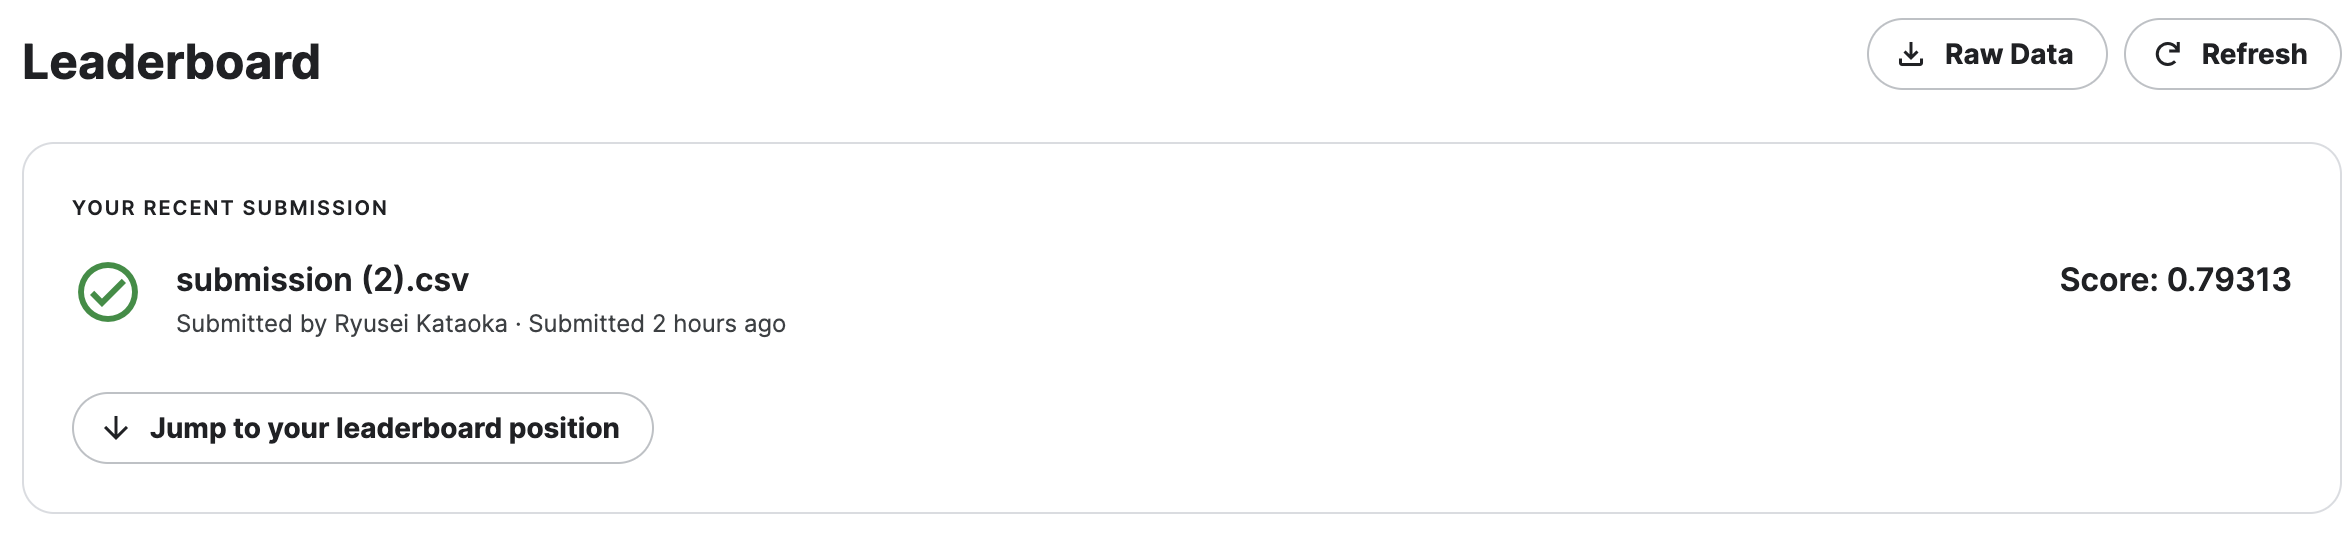

<a id="7"></a>
## 7. Conclusion

In conclusion, the RNN model achieved a score of 0.793, showing it works well for this application. 
It is not shown in the notebook, but I experimented quite a bit with data cleaning as well for this project and it was interesting to see how the formatting of text affected the model. The choice of word embedding or vectorization method also had a substantial influence on the classification accuracy, underlining the importance of selecting an appropriate text representation technique for the problem domain. Adjusting certain settings like the model archetecture, learning rate and using early stopping, is really important to fine-tune our model and get better results. If this project is revisited, different embedding methods should be explored to obtain higher accuracy. 